# Exploratory Data Analysis

## Case Description
* The Ponta Grossa (PG) brewery produces many famous beer brands such as Heineken and Amstel.
* The brewing process has two major phases, a hot phase, and a cold phase (Figure 1). During the hot phase,
two types of malts are milled: a base malt which is light colored and comes in greater amounts and a
**roast malt**, which has a darker color and therefore is used in **giving beer its desired color**.
* These malts are sent to the malt cooker and cooked with water in the mashing step. The grains
are then filtered in the lautering step after which the wort (liquid extracted from the mashing process)
is boiled with hops. The used hop is then filtered in the whirlpool and the hot wort goes on to cool to be
later fermented. **Each production that goes through these phases is call a “batch”**.
* Several KPIs are monitored throughout this process. An important one that characterizes beer
brands is color. Since Ponta Grossa (PG) brewery has an issue of color assertiveness during the brewing process
they have decided to use data science tools to correct beer color index. Since it is **empirical brewing
knowledge that the hot phase of brewing is what most affects final beer color**, PG has decided to
implement an advanced analytics tool that predicts beer color right after the cooling process.
* Based on the data available, **fit a model to predict the color of the cold wort for the AMSTEL
brand only**.
***

Figure 1 - Brewing process diagram<br><br>
![opa](pics/brewing-process.jpg)

## Columns description
* Job ID: Unique identifier of each batch
* Date/Time: Datetime at which the batch process started
* Roast amount (kg): Amount of roast malt used
* 1st (base) malt amount (kg): Amount of 1st base malt used
* 2nd (base) malt amount (kg): Amount of 2nd base malt used (* 1st and 2nd malts are
mixed together during milling but may come from different lots)
* MT – Temperature (ºC): Malt cooker’s aggregated temperature
* MT – Time (s): Period of time that the batch stayed on malt cooker
* WK – Temperature (°C): Wort cooker’s aggregated temperature
* WK – Steam: Wort cooker’s aggregated steam amount
* WK – Time (s): Period of time that the batch stayed on wort cooker
* Total cold wort (HL): Total batch volume of cold wort after cooling
* pH: A batch’s aggregated pH measured during cooling
* Extract (ºP): A batch’s aggregated extract measured during cooling (measures
concentration of sugars in wort)
* Color (EBC) (Model Target): Color value generated by a sensor (measured in European Brewery
Conventions)
* WOC – Time (s): Period of time that the batch stayed on Wort Cooler
* WHP Transfer – Time (s): Whirlpool Transfer Time
* WHP Rest – Time (s): Whirlpool Rest Time
* Roast color (EBC): Color of roast malt
* 1st malt color (EBC): Color of 1st malt
* 2nd malt color (EBC): Color of 2nd malt
* Product: Specified product of one batch (Heineken (HNK), Amstel (AMST)…)

## EBC Color scale
* The EBC colour scale, developed by the Institute of Brewing and the European Brewing Convention, is a recognised method for colour grading of beers, malts and caramel solutions as well as similarly coloured liquids.
* It has a range of **2 to 27 visual units**; yellower pale worts and lagers at the low end of the scale and the amber of dark worts, beers and caramels at the upper end of the scale.
<br>
<br>
Source: https://www.lovibond.com/usa-en/PM/Colour-Measurement/Colour-Scales-Standards/EBC-European-Brewing-Convention

## EDA Outline
1. Business problem definition
1. Schema inspection
1. Data quality checks
1. Univariate analysis
1. Bivariate analysis
1. Timeseries analysis
1. Feature engineering

In [1]:
#load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats as stats

# Split the data.
from sklearn.model_selection import train_test_split

# Utils
# from src.eda_utils import *

# Filter warnings.
import warnings
warnings.filterwarnings('ignore')

### Visualization Settings
%matplotlib inline

mpl.style.use('ggplot') 

mpl.rcParams['axes.facecolor']      = 'white'
mpl.rcParams['axes.linewidth']      = 1
mpl.rcParams['xtick.color']         = 'black'
mpl.rcParams['ytick.color']         = 'black'
mpl.rcParams['grid.color']          = 'lightgray'
mpl.rcParams['figure.dpi']          = 150
mpl.rcParams['axes.grid']           = True
mpl.rcParams['font.size']           = 12

# Set the option to display all columns
pd.set_option('display.max_columns', None)

# Palette Setting
# Setting as the palette
sns.set_palette('viridis')
# Display
sns.color_palette('viridis')

[(0.275191, 0.194905, 0.496005),
 (0.212395, 0.359683, 0.55171),
 (0.153364, 0.497, 0.557724),
 (0.122312, 0.633153, 0.530398),
 (0.288921, 0.758394, 0.428426),
 (0.626579, 0.854645, 0.223353)]

### Business problem definition

* Since beer's color is an important characteristic that defines brand's identity, then, for a particular brand, there must be a specific color range which is desired
* The reason for color prediction is to ensure that there's opportunity to fix the beer's colors, by intervening in the process before it's too late
* It's empirical that the hot phase is what most affects final beer color, and also the amount of roast malt, which is darker, and it's used to give the beer the desired color
* The model should be able to predict the beer color as early as possible, in order to allow intervention, by adjusting the base/roast malt amounts or temperature/time in the machines

### Schema inspection
* Use data only from Amstel batches
* Remove rows where the target [Color] is missing

In [2]:
df = pd.read_csv('data\\raw_data.csv', index_col=0, parse_dates=['Date/Time'])
df.index.name = ''
df = df.query("""Product=='AMST'""").dropna(subset='Color')
df.head()

,Job ID,Date/Time,Roast amount (kg),1st malt amount (kg),2nd malt amount (kg),MT - Temperature,MT - Time,WK - Temperature,WK - Steam,WK - Time,Total cold wort,pH,Extract,Color,WOC - Time,WHP Transfer - Time,WHP Rest - Time,Roast color,1st malt color,2nd malt color,Product
,,,,,,,,,,,,,,,,,,,,,
0,2449959642,2020-10-22 02:50:00,64.499934,16051.99658,3999.860052,67.312984,6546.750,105.408559,6482.25,6365.075,958.900,7.296127,15.309445,14.156956,3126.100,729.925,14.494583,908.375,6.1275,6.02,AMST
1,2449959689,2020-10-22 05:44:00,64.500000,16067.85283,4004.256635,66.933041,6889.675,105.303989,6654.25,5929.700,963.200,7.219022,15.285057,14.270939,3135.775,733.150,14.494583,908.375,6.1275,6.02,AMST
2,2449959720,2020-10-22 07:00:00,64.177513,16062.20908,3996.957605,67.177043,6614.475,105.237753,7363.75,6366.150,1088.975,7.182910,14.155171,13.269140,3492.675,912.675,14.494583,908.375,6.1275,6.02,AMST
8,2449961201,2020-10-26 18:46:00,64.392526,NaN,4010.975385,66.901670,6708.000,105.168039,7245.50,7046.625,954.600,NaN,14.656477,18.693288,3630.275,870.750,14.494583,908.375,6.1275,6.02,AMST
9,2449961221,2020-10-26 20:24:00,64.177513,NaN,4012.168750,67.002759,6526.325,105.133183,6686.50,6744.550,964.275,NaN,14.653028,18.176702,3136.850,740.675,14.494583,908.375,6.1275,6.02,AMST


In [3]:
#fix column headers so it's easier to reference them
replace_chars = str.maketrans({'-': '', ' ': '_', '/': '', '(': '', ')': ''})
df.columns = [col.lower().translate(replace_chars).replace('__', '_') for col in df.columns.to_list()]
df.columns

Index(['job_id', 'datetime', 'roast_amount_kg', '1st_malt_amount_kg',
       '2nd_malt_amount_kg', 'mt_temperature', 'mt_time', 'wk_temperature',
       'wk_steam', 'wk_time', 'total_cold_wort', 'ph', 'extract', 'color',
       'woc_time', 'whp_transfer_time', 'whp_rest_time', 'roast_color',
       '1st_malt_color', '2nd_malt_color', 'product'],
      dtype='object')

In [4]:
#data exploration will be done only on train dataset
np.random.seed(1)
train, _ = train_test_split(df, test_size=0.3)
train.shape

(303, 21)

In [5]:
numeric_cols = ['roast_amount_kg', '1st_malt_amount_kg',
       '2nd_malt_amount_kg', 'mt_temperature', 'mt_time', 'wk_temperature',
       'wk_steam', 'wk_time', 'total_cold_wort', 'ph', 'extract', 'color',
       'woc_time', 'whp_transfer_time', 'whp_rest_time', 'roast_color',
       '1st_malt_color', '2nd_malt_color']

#will keep job_id for tracking

#since the errors from the numeric columns seems to be only from missing values, I'm just gonna coerce it
train[numeric_cols] = train[numeric_cols].apply(pd.to_numeric, errors='coerce')
train.head()

,job_id,datetime,roast_amount_kg,1st_malt_amount_kg,2nd_malt_amount_kg,mt_temperature,mt_time,wk_temperature,wk_steam,wk_time,total_cold_wort,ph,extract,color,woc_time,whp_transfer_time,whp_rest_time,roast_color,1st_malt_color,2nd_malt_color,product
,,,,,,,,,,,,,,,,,,,,,
647,2449971049,2020-11-28 13:31:00,31.724215,15599.37384,4941.402014,70.996205,7398.814287,106.185331,6249.399579,6916.271129,897.864318,5.221870,14.958403,24.936763,2413.274380,720.550236,14.501511,908.375,6.323937,6.057933,AMST
712,2449971114,2020-11-29 05:46:00,41.069792,12879.57796,6724.127336,67.416092,6069.605143,104.764676,7308.137223,6801.776800,736.861602,4.590031,16.220608,20.282576,3121.538014,717.182443,14.496457,908.375,6.176750,5.874294,AMST
543,2449970945,2020-11-27 11:31:00,19.808624,14747.22194,7293.533843,69.916344,6319.301394,104.788182,7463.946876,6382.958715,1167.694656,6.637394,15.719759,21.262716,2221.319494,740.021138,14.484721,908.375,5.866857,6.029878,AMST
747,2449971149,2020-11-29 14:31:00,49.684915,10961.93503,7545.748204,71.445939,6808.499836,104.009587,7048.660420,7167.159633,883.492419,6.192669,14.294979,18.837442,3646.728057,663.996029,14.508367,908.375,6.079628,5.886826,AMST
422,2449970824,2020-11-26 05:16:00,8.853248,16974.86154,6537.570813,59.284431,6071.676856,105.188445,7060.725996,6360.880105,792.621624,5.905363,14.529481,26.471891,3238.004937,767.825285,14.504442,908.375,5.933273,6.021352,AMST


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 303 entries, 647 to 53
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   job_id              303 non-null    int64         
 1   datetime            302 non-null    datetime64[ns]
 2   roast_amount_kg     296 non-null    float64       
 3   1st_malt_amount_kg  301 non-null    float64       
 4   2nd_malt_amount_kg  300 non-null    float64       
 5   mt_temperature      301 non-null    float64       
 6   mt_time             296 non-null    float64       
 7   wk_temperature      297 non-null    float64       
 8   wk_steam            301 non-null    float64       
 9   wk_time             301 non-null    float64       
 10  total_cold_wort     300 non-null    float64       
 11  ph                  300 non-null    float64       
 12  extract             302 non-null    float64       
 13  color               303 non-null    float64       
 14

In [7]:
train[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
roast_amount_kg,296.0,38.689916,17.368194,-9.403970,25.920747,36.394977,52.537369,88.042526
1st_malt_amount_kg,301.0,13776.935534,2181.148081,0.000000,12578.080540,14025.084080,14687.163870,20401.542790
2nd_malt_amount_kg,300.0,6567.482083,1763.178980,-539.836065,5922.463756,6111.154803,7836.682453,11792.203210
mt_temperature,301.0,67.809224,2.695425,59.284431,66.866813,67.142186,68.875940,79.610651
mt_time,296.0,6757.787203,468.192861,5826.561911,6554.460421,6718.750000,6935.159458,11671.275000
wk_temperature,297.0,105.227464,0.607473,97.659771,105.085372,105.269124,105.476061,106.527875
wk_steam,301.0,6744.550604,2783.108823,-31814.284000,6546.750000,6740.083390,7048.660420,34801.068470
wk_time,301.0,6737.577029,570.562985,5217.784151,6461.825000,6706.925000,7000.800846,12621.575000
total_cold_wort,300.0,933.042839,470.875465,-5661.350627,900.292935,958.362500,979.475779,5049.755548
ph,300.0,5.427463,2.114089,-29.229147,5.221676,5.599833,5.849803,7.501595


* There are a few missing entries
* Some columns have negative values, which may be caused by sensor malfunction
* Some outliers can be seem, but I'll assess them with an univariate analysis
* 'color' and 'roast_color' doesn't seem to respect the EBC scale (from 2 to 27)

In [8]:
df['datetime'].describe()

count                              432
mean     2020-11-20 19:44:31.805555712
min                2020-10-22 02:50:00
25%                2020-11-14 13:00:00
50%                2020-11-25 10:46:00
75%                2020-11-27 12:23:30
max                2020-11-30 03:16:00
Name: datetime, dtype: object

* There's at least one month of data available in the full dataset, perhaps I can check for the evolution of some features through time

### Data quality checks
* Missing values
* Duplicate rows
* Inconsistent entries

In [9]:
#check for duplicated entries
train.duplicated().sum()

np.int64(0)

In [10]:
#missing values
train.isna().sum()

job_id                0
datetime              1
roast_amount_kg       7
1st_malt_amount_kg    2
2nd_malt_amount_kg    3
mt_temperature        2
mt_time               7
wk_temperature        6
wk_steam              2
wk_time               2
total_cold_wort       3
ph                    3
extract               1
color                 0
woc_time              3
whp_transfer_time     1
whp_rest_time         5
roast_color           6
1st_malt_color        3
2nd_malt_color        4
product               0
dtype: int64

As there's a very low amount of data, dropping missing rows may be harmful for the model. NaN imputation methods will be considered after univariate analysis, or I may leave it as it is since some tree based models supports NaN values

In [11]:
#check for inconsistent entries
#by the column descriptions, no value can be below zero
(train[numeric_cols] < 0).sum()

roast_amount_kg       3
1st_malt_amount_kg    0
2nd_malt_amount_kg    1
mt_temperature        0
mt_time               0
wk_temperature        0
wk_steam              1
wk_time               0
total_cold_wort       1
ph                    1
extract               1
color                 6
woc_time              0
whp_transfer_time     0
whp_rest_time         0
roast_color           0
1st_malt_color        0
2nd_malt_color        0
dtype: int64

In [12]:
#EBC color scales must be between 2 and 27
#I won't remove values greater than the upper bound because the data may be synthetic
color_cols = ['color', 'roast_color', '1st_malt_color', '2nd_malt_color']
train.loc[(train[color_cols] < 0).any(axis=1)]

,job_id,datetime,roast_amount_kg,1st_malt_amount_kg,2nd_malt_amount_kg,mt_temperature,mt_time,wk_temperature,wk_steam,wk_time,total_cold_wort,ph,extract,color,woc_time,whp_transfer_time,whp_rest_time,roast_color,1st_malt_color,2nd_malt_color,product
,,,,,,,,,,,,,,,,,,,,,
787,2449971189,2020-11-30 00:31:00,50.602023,16212.962200,9638.585909,70.470804,NaN,NaN,NaN,6101.860883,1033.674937,5.394400,15.295314,-1.617232,2714.515004,723.940886,14.489223,908.375,5.914706,6.059294,AMST
206,2449970608,2020-11-23 23:31:00,21.874033,12653.321540,6497.877200,66.965410,7714.405478,105.085372,7262.372129,6368.979746,824.809133,6.059618,15.860496,-12.147439,3664.327989,643.464323,14.505619,NaN,5.933714,6.034150,AMST
517,2449970919,2020-11-27 05:01:00,50.793913,14724.313340,6441.921450,66.170389,7517.577683,105.764280,6672.342932,7043.378747,748.957931,4.327734,15.974412,-0.976929,3058.047903,751.524977,14.504065,908.375,6.100381,6.099756,AMST
312,2449970714,2020-11-25 02:01:00,30.156456,18709.793270,5484.695204,69.935560,6933.821070,105.265444,6865.637224,6640.152025,1255.521830,5.506246,16.521771,-3.717507,2423.274648,665.621843,14.480107,908.375,6.226662,6.087947,AMST
783,2449971185,2020-11-29 23:31:00,63.152685,13564.955360,7136.055889,66.087612,6086.190824,105.212153,6503.298502,6666.051407,NaN,5.597355,17.147313,-96.427001,4408.512168,754.707007,14.499556,908.375,5.948008,6.141954,AMST
619,2449971021,2020-11-28 06:31:00,33.911551,9917.872712,4128.810884,66.941413,5957.765736,105.375593,6421.586886,7134.463146,889.242438,5.822341,14.487359,-4.951118,2787.735623,816.462119,14.491759,908.375,6.112208,5.994838,AMST


### Time series analysis
* Since each batch's datetime is available, let's plot the distribution of features through time

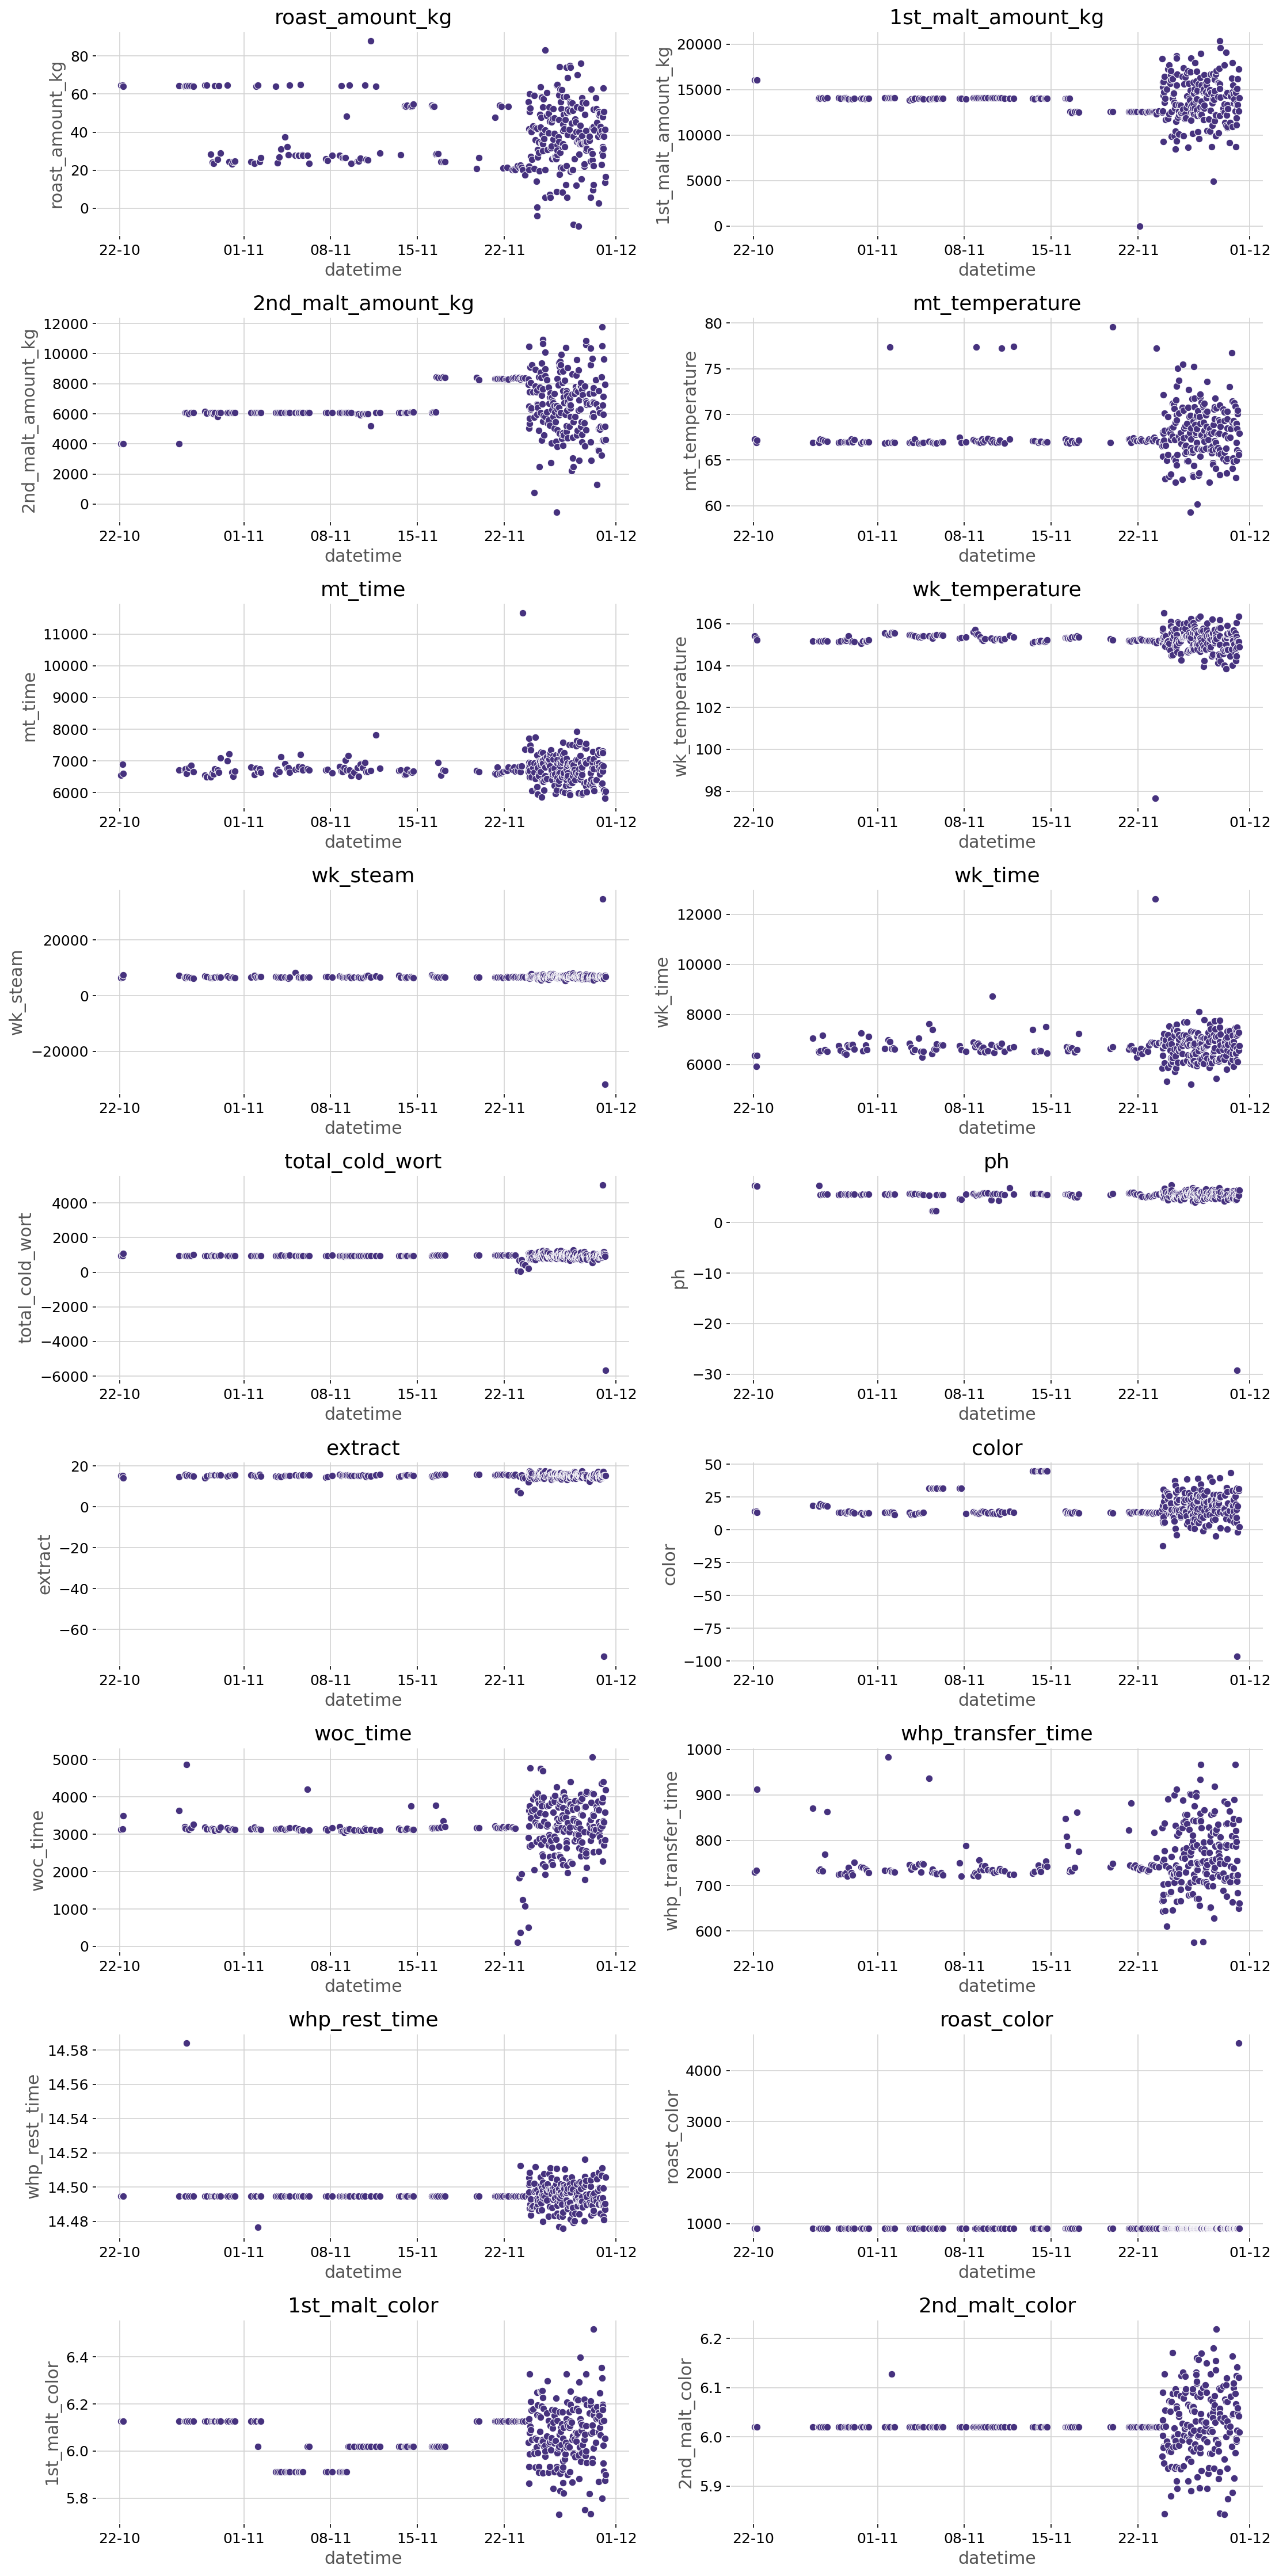

In [13]:
#set axis format
date_formatter = mpl.dates.DateFormatter('%d-%m')

ordered_train = train.sort_values(by='datetime').copy()

fig, axs = plt.subplots(9, 2, figsize=(15, 30))
axs = axs.flatten()

for idx, feature in enumerate(numeric_cols):
    sns.scatterplot(ordered_train, x='datetime', y=feature, ax=axs[idx])
    axs[idx].set_title(feature)
    axs[idx].xaxis.set_major_formatter(date_formatter)

plt.tight_layout()
plt.show()

* The distribution of features seems random after 23/11/2020, perhaps something happened with Ponta Grossa's sensors in this ~week ?
* The target variable [color] distribution seems to have a particular average of values, with a few days where the color suddenly changed. I'll place a confidence interval around the median (since there's a few undesired colors, the mean would be skewed) of the data to be the correct color, and any value outside this range to be an undesired color
* Let's see how data correlate after dropping this particular week

In [14]:
#remove the week with random data
train = ordered_train.loc[ordered_train['datetime'] < pd.to_datetime('2020-11-23')]

In [39]:
median = train['color'].median()
MAD = stats.median_abs_deviation(train['color'])
desired_interval = median - 2 * MAD, median + 2 * MAD
desired_interval

(np.float64(12.090611860000001), np.float64(14.591976579999999))

In [47]:
train['color_range'] = np.select([(train['color'] > desired_interval[1]), (train['color'] < desired_interval[0])],
                                   ['above', 'below'],
                                   'correct')

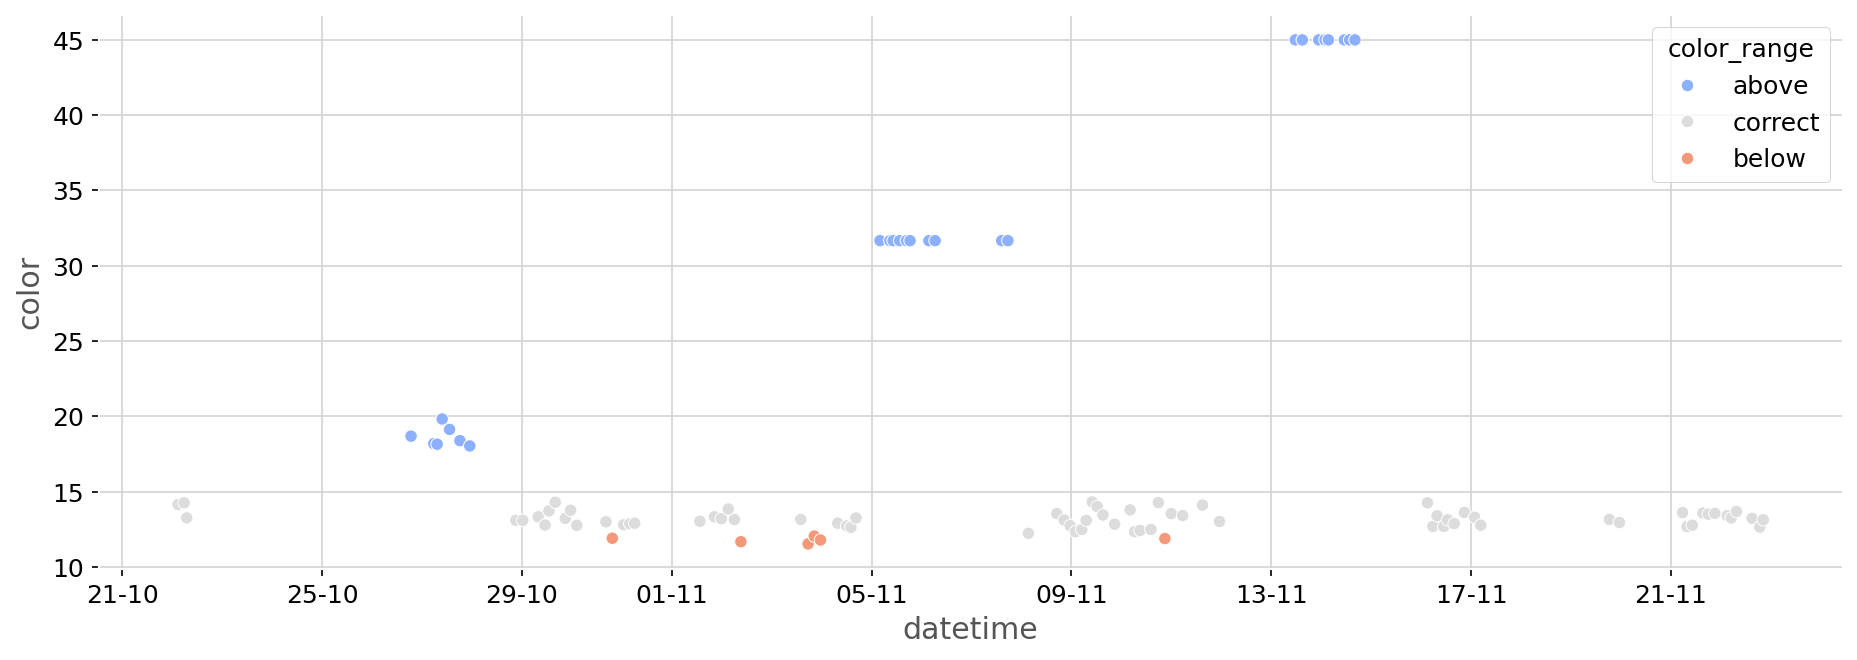

In [49]:
sns.scatterplot(data=train, x='datetime', y='color', hue='color_range', palette='coolwarm', hue_order=['above', 'correct', 'below'])
plt.gca().xaxis.set_major_formatter(date_formatter)
plt.gcf().set_figwidth(15)

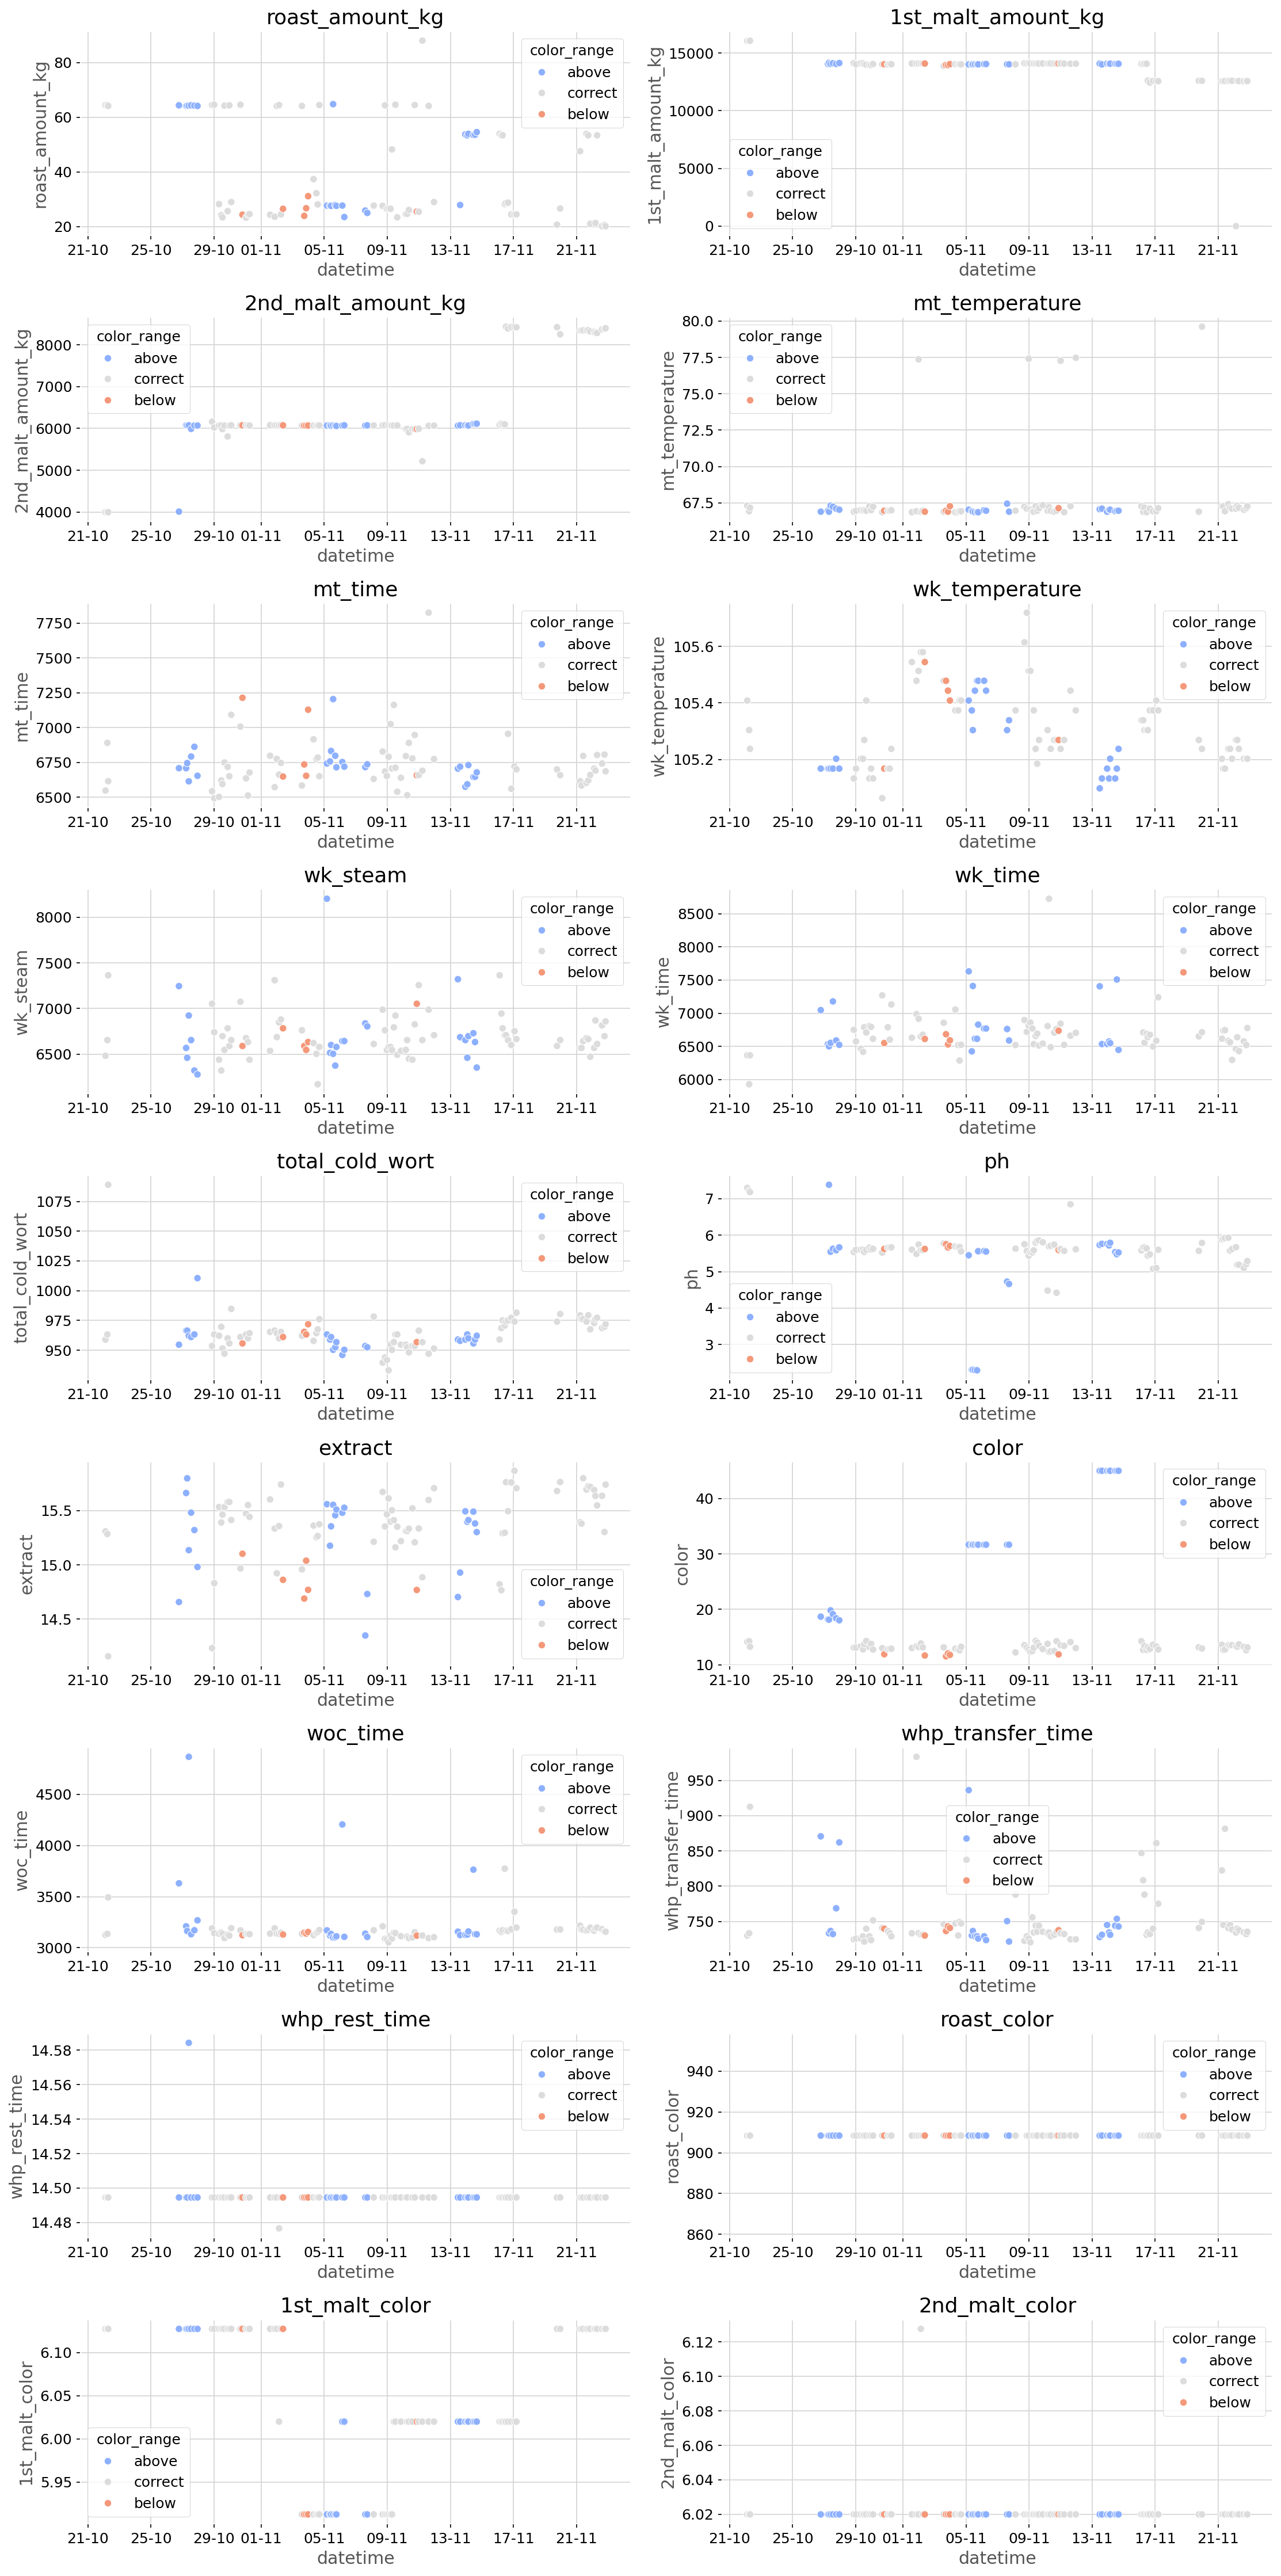

In [52]:
#let's plot the data again

fig, axs = plt.subplots(9, 2, figsize=(15, 30))
axs = axs.flatten()

for idx, feature in enumerate(numeric_cols):
    sns.scatterplot(train, x='datetime', y=feature, ax=axs[idx], hue='color_range', palette='coolwarm', hue_order=['above', 'correct', 'below'])
    axs[idx].set_title(feature)
    axs[idx].xaxis.set_major_formatter(date_formatter)

plt.tight_layout()
plt.show()

### Univariate analysis

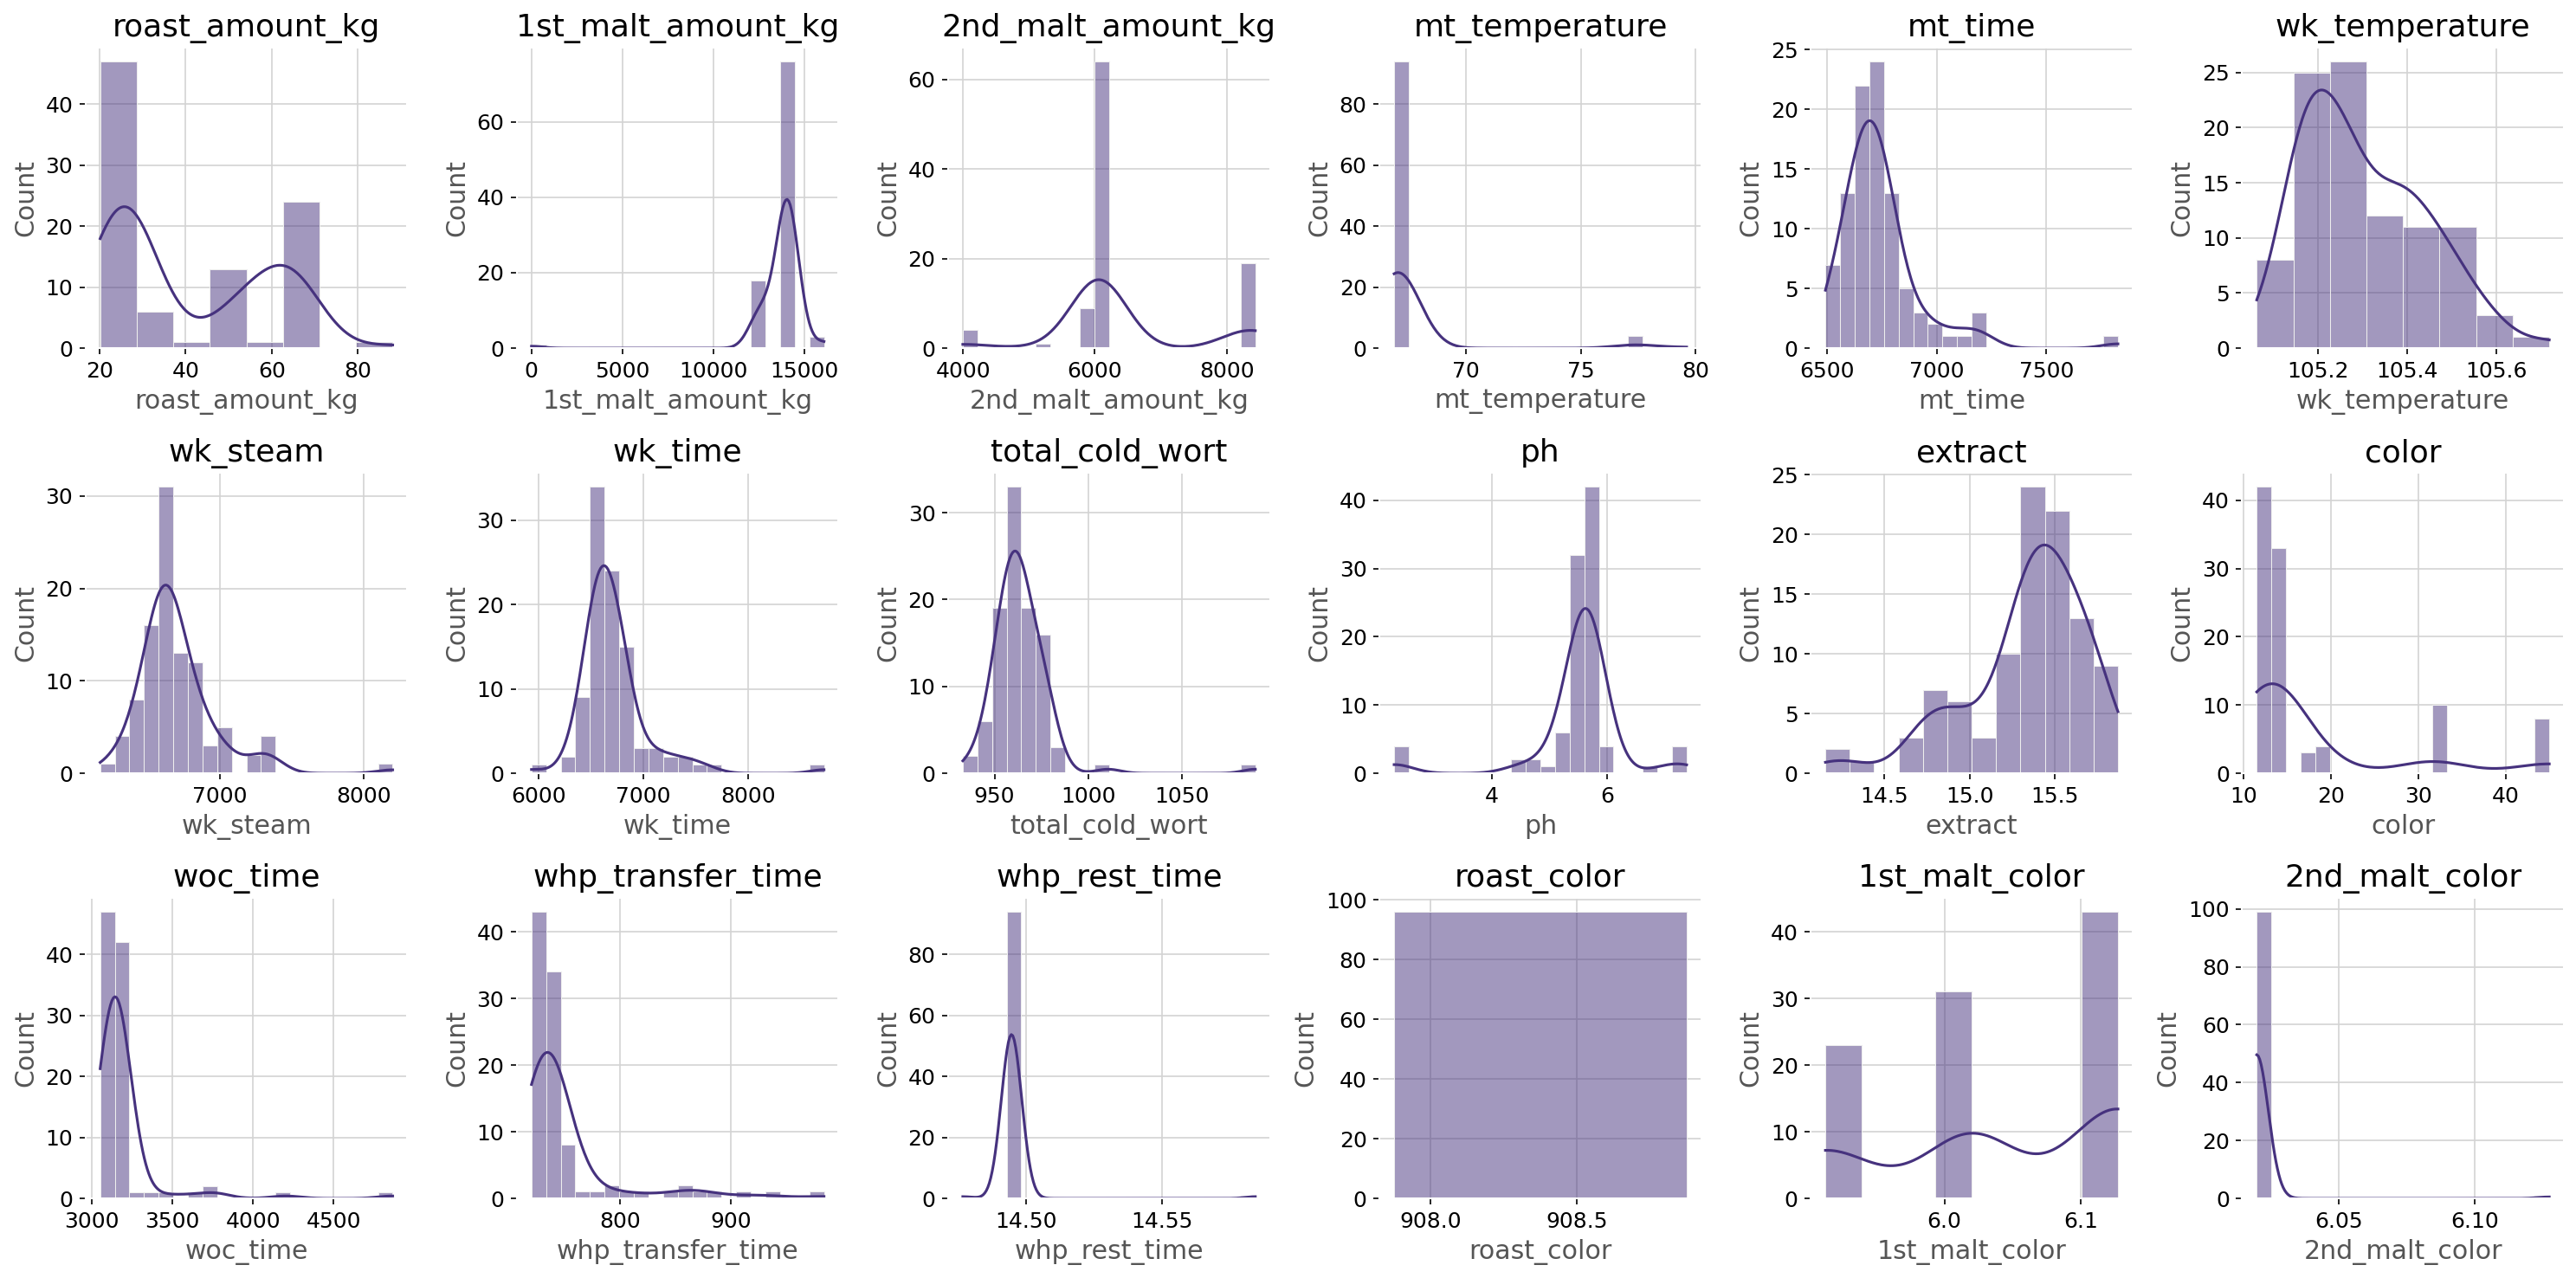

In [55]:
fig, axs = plt.subplots(3, 6, figsize=(20, 10))
axs = axs.flatten()

for idx, feature in enumerate(numeric_cols):
    sns.histplot(train[feature], kde=True, ax=axs[idx])
    axs[idx].set_title(feature)

plt.tight_layout()
plt.show()

There seems to be outliers, perhaps caused by sensor failure

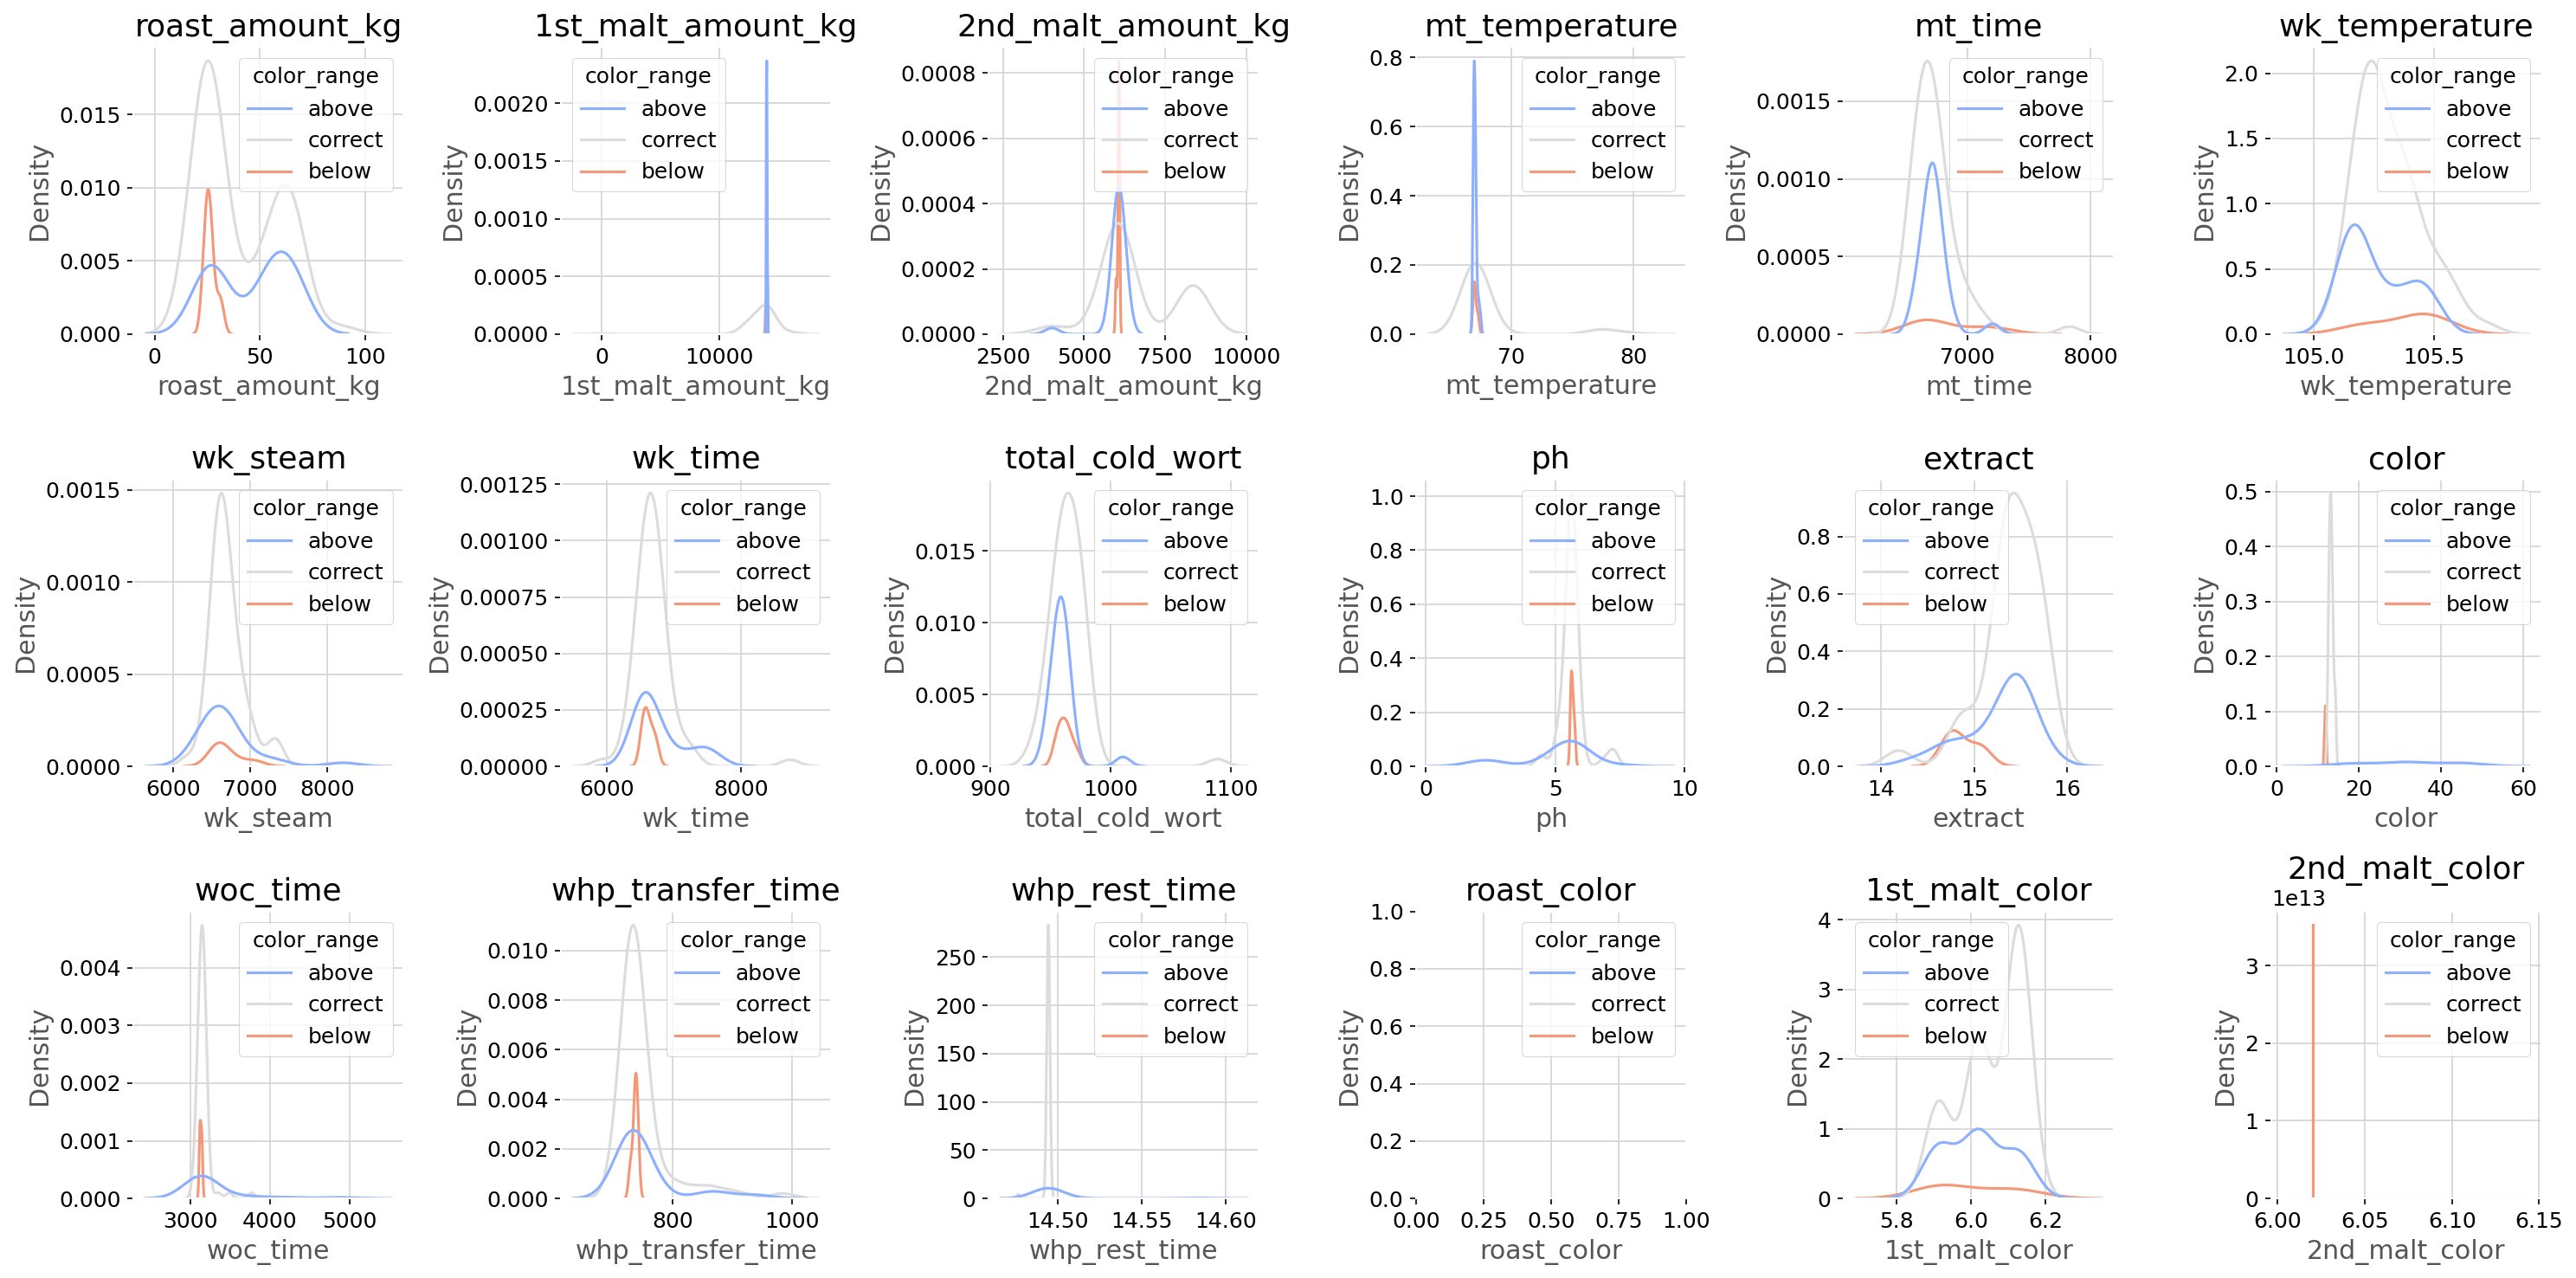

In [71]:
#now let's check if the distribution changes as color goes into undesired zone

fig, axs = plt.subplots(3, 6, figsize=(20, 10))
axs = axs.flatten()


for idx, feature in enumerate(numeric_cols):
    sns.kdeplot(data=train, x=feature, hue='color_range', palette='coolwarm', hue_order=['above', 'correct', 'below'], ax=axs[idx])
    axs[idx].set_title(feature)

plt.tight_layout()
plt.show()


### Bivariate analysis

<Axes: >

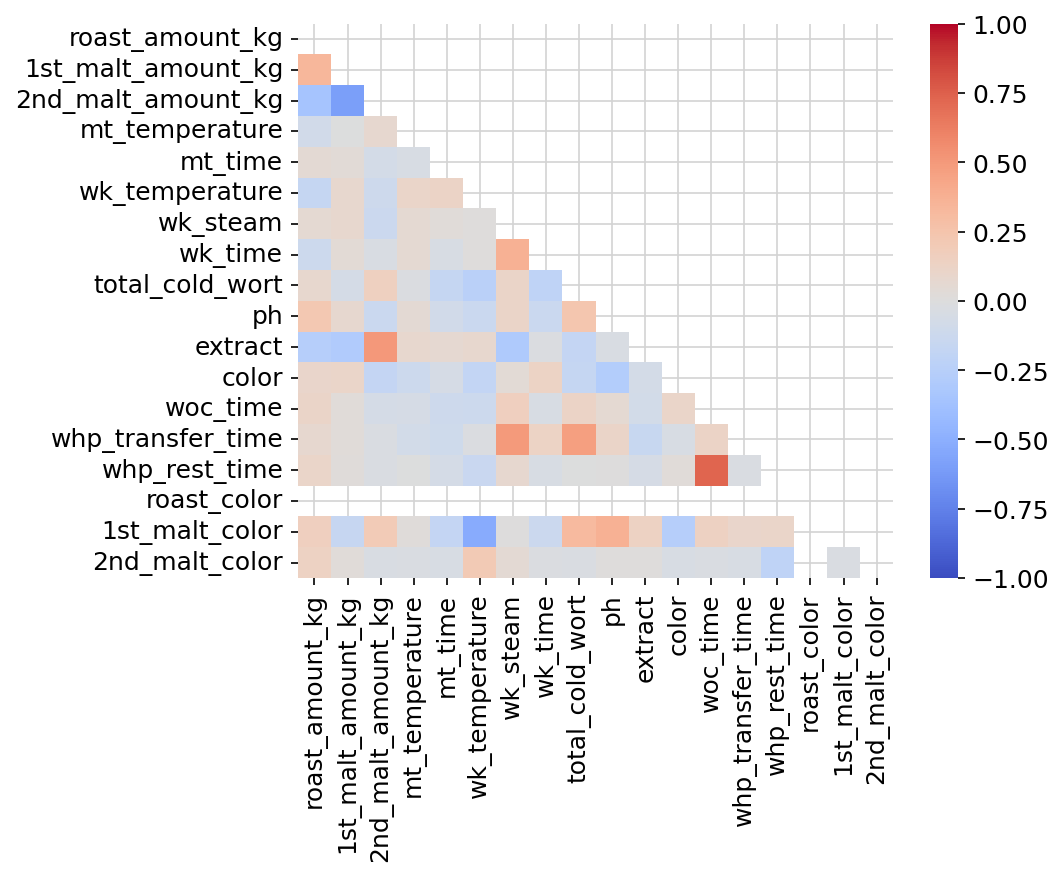

In [18]:
corr = train[numeric_cols].corr()
sns.heatmap(corr.mask(np.triu(np.ones_like(corr, dtype=bool))), vmin=-1, vmax=1, cmap='coolwarm')

* Some features are related with each other and not the target feature. This may introduce multicolinearity which is harmful for linear models

In [19]:
corr['color'].sort_values(ascending=False)

color                 1.000000
wk_time               0.131355
1st_malt_amount_kg    0.108939
woc_time              0.107966
roast_amount_kg       0.098331
wk_steam              0.039645
whp_rest_time         0.026002
2nd_malt_color       -0.041706
whp_transfer_time    -0.046099
mt_time              -0.057295
extract              -0.076544
mt_temperature       -0.121353
total_cold_wort      -0.168547
2nd_malt_amount_kg   -0.174713
wk_temperature       -0.181316
1st_malt_color       -0.258834
ph                   -0.277290
roast_color                NaN
Name: color, dtype: float64

* Relationship between features are rather weak

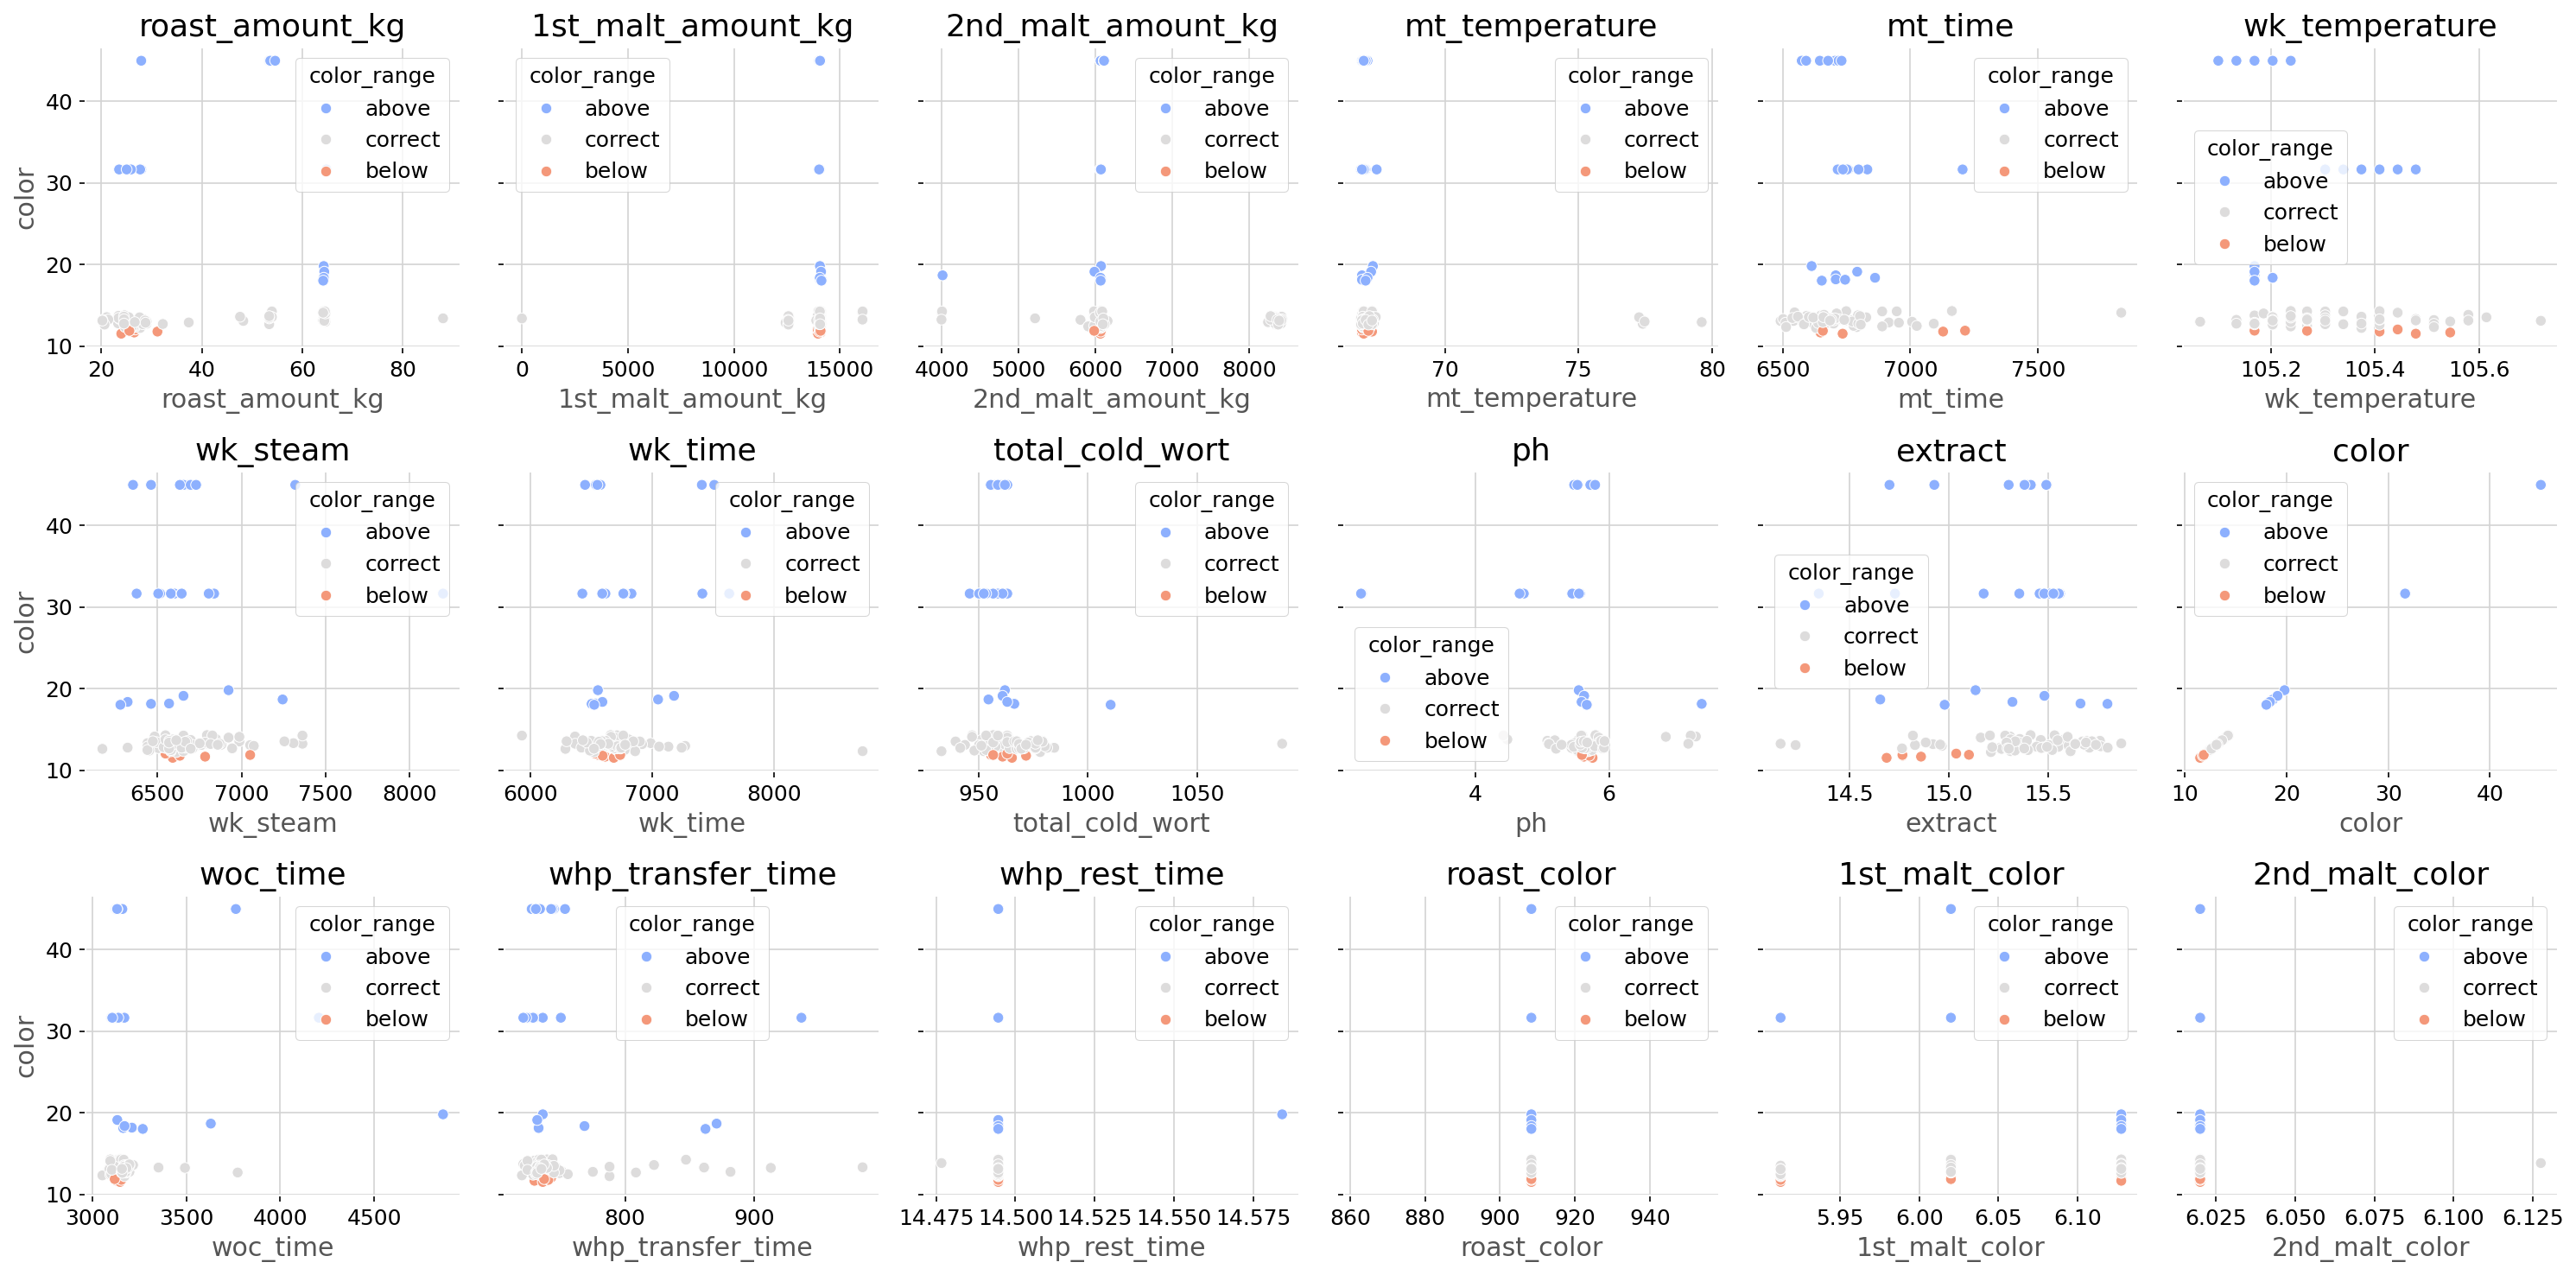

In [62]:
fig, axs = plt.subplots(3, 6, figsize=(20, 10), sharey=True)
axs = axs.flatten()

for idx, feature in enumerate(numeric_cols):
    sns.scatterplot(train, x=feature, y='color', ax=axs[idx], hue='color_range', palette='coolwarm', hue_order=['above', 'correct', 'below'])
    axs[idx].set_title(feature)

plt.tight_layout()
plt.show()

* No feature has significant correlation with the target variable neither with themselves. Any machine learning model will be as good as random guessing in this scenario

### Feature engineering

Some ratios or interactions are possible to be included in the model, like the following:
* 1st/2nd malt amount ratio
* malt/roast amount ratio
* 

## EDA Conclusions